In [ ]:
!pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [56]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

In [32]:
df = pd.read_excel("goldprice2001.2.1--2024.1.1.xlsx")
df['Gold_Close_prev'] = df['Gold Price'].shift(1)
df['Gold_Close_prev'].fillna(method='bfill', inplace=True)

t = []

for i in df["Date"]:

  ts = pd.Timestamp(i)
  timestamp = ts.timestamp()

  t.append(timestamp)
df["Time"] = t

<ipython-input-32-63466e69fe93>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gold_Close_prev'].fillna(method='bfill', inplace=True)
<ipython-input-32-63466e69fe93>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Gold_Close_prev'].fillna(method='bfill', inplace=True)


In [42]:
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, Subset

scaler = MinMaxScaler()
features = scaler.fit_transform(df[['USD Index','CPI','Fed Rate','sp500','Gold_Close_prev']])
target = df['Gold Price']

X, y = [],[]
for i in range(len(target) - 10):
    X.append(features[i:i+10])
    y.append(target[i+10])

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

l = len(X)

data = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))

train_data = Subset(data, range(0, int(l * 0.7)))
val_data   = Subset(data, range(int(l * 0.7), int(l * 0.85)))
test_data  = Subset(data, range(int(l * 0.85), l))

train = DataLoader(train_data, batch_size=32, shuffle=True)
val = DataLoader(val_data, batch_size=32)
test = DataLoader(test_data, batch_size=32)

In [34]:
from torchdiffeq import odeint

class ResMLPBlock(nn.Module):
    def __init__(self, dim=128, input_dim=5, seq_length=10):
        super().__init__()
        self.embedding = nn.Linear(input_dim * seq_length, dim)
        layers = [
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim),
            nn.GELU(),]*2
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.embedding(x)
        x = self.mlp(x)
        return x

class ODE(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim),
            nn.GELU(),)

    def forward(self, t, x):
        return self.net(x)

class ODEBlock(nn.Module):
    def __init__(self, ode_func, solver="euler", t=(0.0, 1.0)):
        super().__init__()
        self.odeint = odeint
        self.ode_func = ode_func
        self.register_buffer("t", torch.tensor(t, dtype=torch.float32))
        self.solver = solver

    def forward(self, x):
        out = self.odeint(self.ode_func, x, self.t, method=self.solver)
        return out[-1]

class ResMLP_NeuralODE(nn.Module):
    def __init__(self, solver, input_dim=5, seq_length=10, hidden_dim=128):
        super().__init__()
        self.resmlp = ResMLPBlock(hidden_dim, input_dim, seq_length)
        self.ode_block = ODEBlock(ODE(hidden_dim), solver)
        self.head = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.resmlp(x)
        x = self.ode_block(x)
        return self.head(x)


In [50]:
def training(model, device, epochs, lr, wd, train =train, val = val, tuning = False):
    criterion = nn.MSELoss()
    optimizor = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    best_val = float('inf')
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        for X, y in train:
            X, y = X.to(device), y.to(device).unsqueeze(1)
            optimizor.zero_grad()
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizor.step()
            train_loss += loss.item() * X.size(0)
        train_loss /= len(train.dataset)

        model.eval()
        with torch.no_grad():
            valid_loss = 0.0
            for X, y in val:
                X, y = X.to(device), y.to(device).unsqueeze(1)
                valid_loss += criterion(model(X), y).item() * X.size(0)
            valid_loss /= len(val.dataset)
        train_loss = round(train_loss,4)
        valid_loss = round(valid_loss,4)
        if tuning ==False:
          print(f"epoch: {epoch}, train loss: {train_loss}, val loss: {valid_loss}")
        if valid_loss < best_val:
            best_val = valid_loss
            torch.save(model.state_dict(), "best_model.pt")
    model.load_state_dict(torch.load("best_model.pt"))


def predict(model, device, test = test):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for X, y in test:
            X = X.to(device)
            preds.append(model(X).squeeze(1).cpu().numpy())
            trues.append(y.numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    return preds, trues


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def run(lr, wd, solver,tain = train, val = val,seq_length = 10,hidden_dim = 128, batch_size = 32, tuning = False):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ResMLP_NeuralODE(solver, 5, seq_length, hidden_dim).to(device)
    training(model, device, 50, lr, wd, tuning = tuning)

    pred, true = predict(model, device)
    r2 = round(r2_score(true, pred),4)
    rmse = round(np.sqrt(mean_squared_error(true, pred)),4)
    mae = round(mean_absolute_error(true, pred),4)
    if tuning ==False:
      print(f"Test R²  : {r2}")
      print(f"Test RMSE: {rmse}")
      print(f"Test MAE : {mae}")

    return r2, rmse, mae

In [30]:
result = pd.DataFrame(columns=['Solver', 'Learning Rate', 'Weight Decay', 'RMSE', 'MAE', "R^2"])
lrs = [0.0003, 0.001,0.003]
wds = [0, 0.0001, 0.001]
solvers = ['euler', 'rk4', 'dopri5']
for lr in lrs:
  for wd in wds:
    for solver in solvers:
      r2, rmse, mae = run(lr = lr, wd = wd, solver = solver, tuning = True)
      result.loc[len(result)] = [solver, lr, wd, rmse, mae, r2]
result.to_excel("Hyperparameter Tuning Result.xlsx")

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResMLP_NeuralODE("rk4", 5, 10, 128).to(device)
training(model, device, 50, 0.0003, 0.001)

resmlpodepred, true = predict(model, device)

r2 = round(r2_score(true, resmlpodepred),4)
rmse = round(np.sqrt(mean_squared_error(true, resmlpodepred)),4)
mae = round(mean_absolute_error(true, resmlpodepred),4)
print(f"Test R²  : {r2}")
print(f"Test RMSE: {rmse}")
print(f"Test MAE : {mae}")

epoch: 1, train loss: 455262.0145, val loss: 78519.4531
epoch: 2, train loss: 3983.0003, val loss: 1826.83
epoch: 3, train loss: 914.6606, val loss: 851.9689
epoch: 4, train loss: 989.0461, val loss: 1168.6112
epoch: 5, train loss: 848.0753, val loss: 1679.76
epoch: 6, train loss: 976.1943, val loss: 758.4581
epoch: 7, train loss: 892.8508, val loss: 924.6314
epoch: 8, train loss: 819.1872, val loss: 821.4668
epoch: 9, train loss: 802.8668, val loss: 784.2855
epoch: 10, train loss: 751.5349, val loss: 1559.9776
epoch: 11, train loss: 798.8552, val loss: 1325.7367
epoch: 12, train loss: 1078.4734, val loss: 1488.0303
epoch: 13, train loss: 853.8391, val loss: 810.5234
epoch: 14, train loss: 1035.9275, val loss: 835.7205
epoch: 15, train loss: 776.5044, val loss: 862.3933
epoch: 16, train loss: 697.5598, val loss: 733.4807
epoch: 17, train loss: 755.1555, val loss: 739.361
epoch: 18, train loss: 776.7776, val loss: 762.1539
epoch: 19, train loss: 692.829, val loss: 1158.6483
epoch: 20, t

epoch: 1, train loss: 504868.3337, val loss: 89676.2038
epoch: 2, train loss: 7990.6154, val loss: 30079.7787
epoch: 3, train loss: 2891.2073, val loss: 19760.6227
epoch: 4, train loss: 2159.2511, val loss: 19775.8825
epoch: 5, train loss: 1770.318, val loss: 16619.6815
epoch: 6, train loss: 1461.0123, val loss: 12038.5968
epoch: 7, train loss: 1136.0897, val loss: 18265.8699
epoch: 8, train loss: 1093.5018, val loss: 15160.034
epoch: 9, train loss: 905.8018, val loss: 11423.6104
epoch: 10, train loss: 819.3701, val loss: 12729.2421
epoch: 11, train loss: 777.9402, val loss: 8474.6516
epoch: 12, train loss: 723.2673, val loss: 6989.0997
epoch: 13, train loss: 859.5004, val loss: 5496.0485
epoch: 14, train loss: 689.7593, val loss: 7148.7667
epoch: 15, train loss: 639.4696, val loss: 5187.6604
epoch: 16, train loss: 596.2573, val loss: 4649.3846
epoch: 17, train loss: 607.4927, val loss: 5777.8008
epoch: 18, train loss: 785.452, val loss: 6189.6266
epoch: 19, train loss: 666.8046, val l

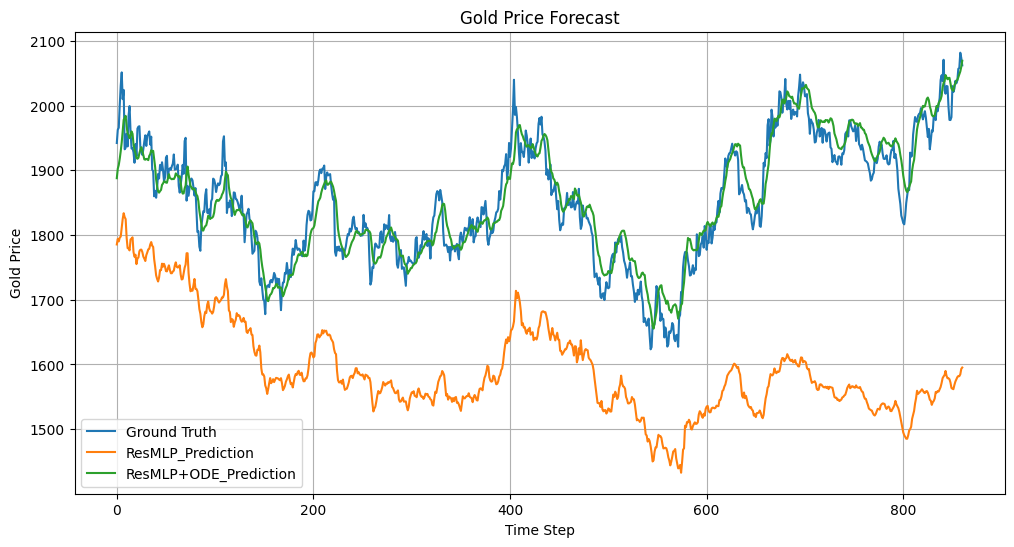

In [55]:
import matplotlib.pyplot as plt
class ResMLP(nn.Module):
    def __init__(self, dim=128, input_dim=5, seq_length=10, depth=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim * seq_length, dim)
        layers = [
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim),
            nn.GELU(),]*depth
        self.mlp = nn.Sequential(*layers)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.embedding(x)
        residual = x
        x = self.norm(x)
        x = self.mlp(x)
        return residual + x

class ResMLPPredict(nn.Module):
    def __init__(self, dim=128, input_dim=5, seq_length=10, depth=2):
        super().__init__()
        self.backbone = ResMLP(dim, input_dim, seq_length, depth)
        self.head = nn.Linear(dim, 1)

    def forward(self, x):
        h = self.backbone(x)
        return self.head(h)


ResMLP = ResMLPPredict().to(device)
training(ResMLP, device, 50, 0.0003, 0.001)

pred, true = predict(ResMLP, device)

r2 = round(r2_score(true, pred),4)
rmse = round(np.sqrt(mean_squared_error(true, pred)),4)
mae = round(mean_absolute_error(true, pred),4)
print(f"Test R²  : {r2}")
print(f"Test RMSE: {rmse}")
print(f"Test MAE : {mae}")

plt.figure(figsize=(12, 6))
plt.plot(true, label='Ground Truth')
plt.plot(pred, label='ResMLP_Prediction')
plt.plot(resmlpodepred, label='ResMLP+ODE_Prediction')
plt.title('Gold Price Forecast')
plt.xlabel('Time Step')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.savefig("ResMLP.jpg")
plt.show()
